In [1]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,group
0,TM_P1911_190,2
1,TM_P1912_030,2
2,TM_P1912_032,2
3,TM_P1912_033,2
4,TM_P1912_034,2
...,...,...
192,TM_M2012_138,1
193,TM_M2012_046,1
194,TM_M2012_129,1
195,TM_M2012_128,1


In [4]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [5]:
qm = QuantMatrix(
    #quantification_file="/home/aaron/projects/dpks/notebooks/ml_api/quantified_proteins.tsv", 
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter().normalize(method="mean").quantify(method="top_n", top_n=3, summarization_method="mean").impute(method="uniform_percentile")

/home/aaron/projects/dpks/dpks/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [6]:
qm = qm.compare(
    method="linregress",
    min_samples_per_group=10,
    comparisons=[(2, 1)]
)

In [7]:
X, y = qm.to_ml()

In [8]:
X

,P08603,P02671,P01042,P00450,P05156,P02452,P10643,B9A064,P02787,P00738,...,P01616,P17538,P55083,P08195,P18136,P07333,Q06323,P16035,O95633,O00194
TM_P1911_190,26.573443,30.414030,25.186033,27.074122,23.354331,25.008606,23.949753,28.820547,28.248075,32.259085,...,21.490898,13.433553,15.815494,13.698658,16.344202,14.135478,15.532579,13.666680,15.395138,16.238835
TM_P1912_030,27.083506,29.167885,25.495279,26.980717,22.145539,18.767536,23.104178,29.009921,28.572139,31.859478,...,21.999736,14.592292,15.403833,18.354746,20.666000,20.647897,13.885555,14.782459,14.664527,13.313386
TM_P1912_032,26.710508,30.201201,24.754007,26.575800,23.675778,25.708159,23.172960,28.372428,27.652258,31.378488,...,25.521041,15.191844,15.749417,16.244500,15.575368,13.784118,14.799658,14.002143,13.581673,16.254676
TM_P1912_033,27.076933,29.626100,25.381406,27.178537,22.901699,18.265912,23.237137,29.096738,29.065703,31.465902,...,21.794770,18.087066,16.294583,18.488034,19.326489,20.980876,13.353325,15.172306,15.082963,16.637850
TM_P1912_034,26.958747,29.407725,25.513667,27.046556,22.864036,16.991510,23.242471,29.072251,29.296427,31.450523,...,21.752500,18.851191,16.453398,15.828442,14.343789,20.382838,13.757622,15.242378,15.112278,15.648711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TM_M2012_138,25.606155,28.661465,26.275698,26.450327,23.163942,26.268418,22.790413,29.282766,28.947672,28.896758,...,22.248459,15.607325,15.240530,19.117308,15.852847,20.059113,20.598890,18.714571,15.659226,16.431368
TM_M2012_046,25.755329,30.276096,25.762032,26.503985,23.601898,16.270267,23.301275,26.555082,29.080204,31.591836,...,18.533788,19.981019,13.931177,14.133103,14.226272,15.762458,13.469083,15.131592,15.815146,13.953851
TM_M2012_129,25.693048,30.093610,25.711535,26.364655,23.505068,24.600329,23.195304,27.324822,28.467790,31.172964,...,21.671989,18.636890,14.077345,14.699899,15.455351,16.251330,14.180945,17.878274,14.403010,15.572072
TM_M2012_128,25.891135,30.090042,25.849126,26.521138,23.624856,25.302674,23.421284,27.219719,28.669361,31.215393,...,19.938109,19.070976,16.221876,15.963144,15.407632,14.824764,16.064057,14.146344,14.449776,14.256559


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[:] = scaler.fit_transform(X[:])

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

# clf = xgboost.XGBClassifier(
#     max_depth=2,
#     #subsample=0.5,
#     reg_lambda=2,
#     # objective="binary:logitraw",
#     # seed=42,
#     # eval_metric="logloss",
# )
#clf = HistGradientBoostingClassifier()
clf = LogisticRegression()
#clf = SVC(kernel="linear")
#clf = RandomForestClassifier()
#clf = Lasso()
#clf = AdaBoostClassifier()
#clf = SGDClassifier()

clf.fit(X.values, y.values.ravel())

LogisticRegression()

In [11]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(
    clf,
    X.values,
    y.values.ravel(),
    scoring="neg_log_loss",
    n_jobs=1,
    #max_samples=0.5,
    n_repeats=1,
)

In [12]:
feature_importances = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances['importances_mean']
    }
)

In [13]:
feature_importances.sort_values("importance", ascending=False)

,feature,importance
425,P01880,0.000811
41,P06727,0.000771
39,Q04756,0.000567
395,P14151,0.000469
356,Q96PD5,0.000441
...,...,...
505,P07477,-0.000014
36,P07996,-0.000014
197,A6NCN2,-0.000015
213,P02655,-0.000017


<Axes: xlabel='importance', ylabel='feature'>

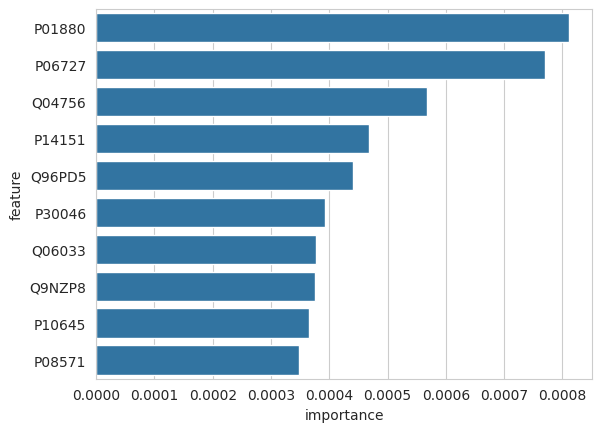

In [14]:
sns.barplot(x="importance", y="feature", data=feature_importances.sort_values("importance", ascending=False).head(10))

In [15]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier


class FeatureImportance:

    all_predictions: np.ndarray
    feature_names: list[str]
    def __init__(self, n_iterations: int = 3, feature_names: list[str] = None):
        self.n_iterations = n_iterations
        self.feature_names = feature_names

    def fit(self, clf, X) -> None:

        decision_function = getattr(clf, "decision_function", None)

        if callable(decision_function):
            all_predictions = clf.decision_function(X)
        else:
            all_predictions = clf.predict_proba(X)[:, 1]

        global_explanations = []

        local_explanations = []

        for i in range(X.shape[1]):

            feature_slice = X[:, i].copy()

            X_copy = X.copy()

            losses = []

            for _ in range(self.n_iterations):
                np.random.shuffle(feature_slice)

                X_copy[:, i] = feature_slice

                if callable(decision_function):
                    new_predictions = clf.decision_function(X_copy)
                else:
                    new_predictions = clf.predict_proba(X_copy)[:, 1]

                local_lossses = all_predictions - new_predictions

                losses.append(
                    local_lossses
                )

            local_explanation = np.mean(np.array(losses), axis=0)

            local_explanations.append(local_explanation)
            # print(np.std(losses) / np.mean(losses))

            global_explanations.append(
                np.mean(
                    np.mean(np.abs(local_explanation))
                )
            )

        self.local_explanations = np.array(local_explanations)

        self.global_explanations = np.array(global_explanations)



In [16]:
#from dpks.inspection import FeatureImportance

importance_calculator = FeatureImportance(
    n_iterations=3,
    feature_names=X.columns.values,
)

importance_calculator.fit(clf, X.values)

In [17]:
feature_importances['loss_importance'] = importance_calculator.global_explanations

In [18]:
feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance
553,O00194,0.000011,6.179966
552,O95633,0.000005,6.179366
550,Q06323,0.000049,6.176008
551,P16035,0.000014,6.174453
549,P07333,0.000003,6.167487
...,...,...,...
4,P05156,0.000004,0.134786
3,P00450,0.000016,0.132413
2,P01042,0.000051,0.109324
1,P02671,0.000003,0.099906


<Axes: xlabel='loss_importance', ylabel='feature'>

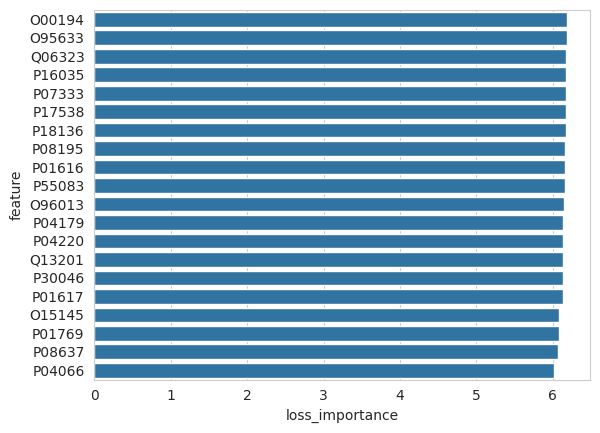

In [19]:
sns.barplot(
    data=feature_importances.sort_values("loss_importance", ascending=False).head(20),
    x="loss_importance",
    y="feature"
)

In [22]:
import shap

In [23]:
explainer = shap.LinearExplainer(clf, X)
#explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

In [24]:
feature_importances['shap_importance'] = np.mean(abs(shap_values.values), axis=0)

In [25]:
feature_importances.sort_values("shap_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
41,P06727,1.121009e-03,0.329193,0.282649
425,P01880,8.048593e-04,0.290276,0.238949
356,Q96PD5,5.532691e-04,0.225790,0.202337
39,Q04756,4.072090e-04,0.223920,0.187789
395,P14151,3.632153e-04,0.207488,0.185357
...,...,...,...,...
442,P04433,2.923094e-07,0.000530,0.000451
48,P01009,-1.745013e-07,0.000484,0.000442
71,Q6UWP8,7.043119e-08,0.000396,0.000357
330,P11142,-4.638080e-08,0.000257,0.000234


<Axes: xlabel='shap_importance', ylabel='feature'>

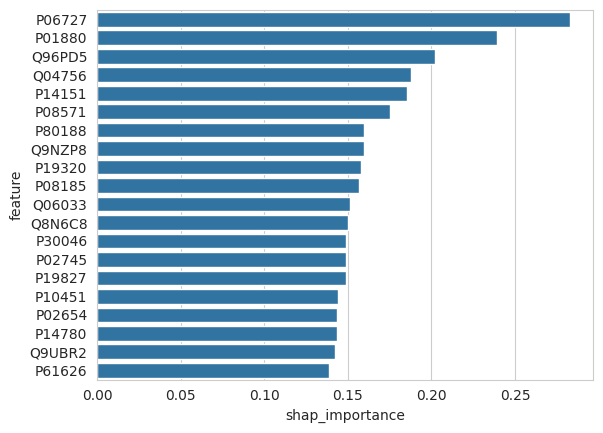

In [26]:
sns.barplot(
    data=feature_importances.sort_values("shap_importance", ascending=False).head(20),
    x="shap_importance",
    y="feature"
)

<Axes: xlabel='shap_importance', ylabel='loss_importance'>

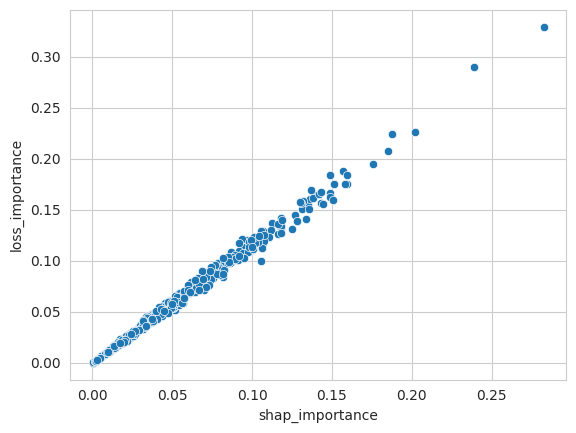

In [27]:
sns.scatterplot(
    data=feature_importances,
    x="shap_importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='loss_importance'>

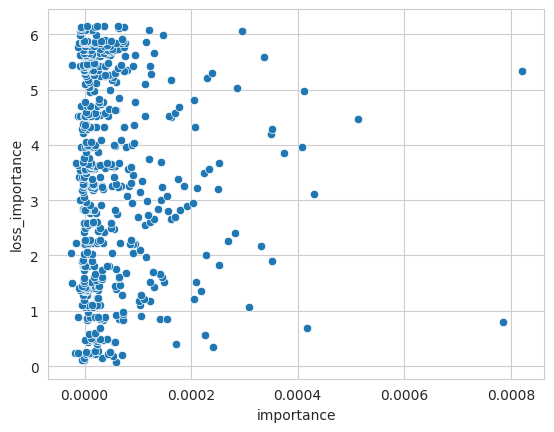

In [25]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='shap_importance'>

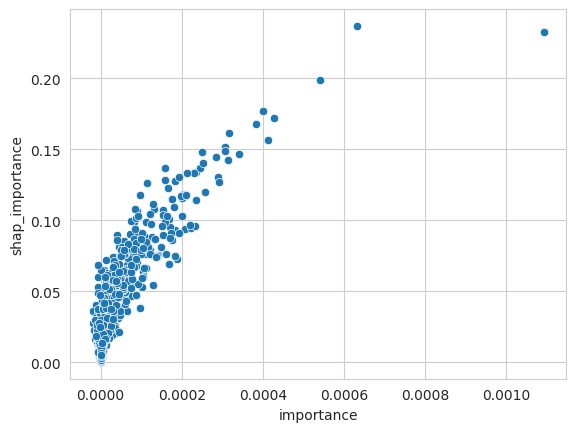

In [44]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="shap_importance",
)

In [45]:
explanations = pd.DataFrame(
    importance_calculator.local_explanations.T,
    columns=list(X.columns.values),
    index=list(X.index.values)
)

In [46]:
explanations = explanations.join(y)

In [47]:
explanations_melted = explanations.reset_index(names="Sample").melt(
    id_vars=["Sample", "label"]
)

In [48]:
feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
425,P01880,1.091748e-03,0.275953,0.232658
41,P06727,6.328663e-04,0.253561,0.236930
356,Q96PD5,5.405339e-04,0.229992,0.198780
395,P14151,4.282772e-04,0.201487,0.172184
39,Q04756,4.009362e-04,0.201022,0.176652
...,...,...,...,...
288,P37802,1.362254e-07,0.000806,0.000691
28,O00391,3.957301e-07,0.000799,0.000704
479,P06310,-2.834353e-07,0.000713,0.000703
4,P05156,8.638108e-08,0.000290,0.000256


In [49]:
explanations_melted

,Sample,label,variable,value
0,TM_P1911_190,1,P08603,-0.110572
1,TM_P1912_030,1,P08603,-0.117269
2,TM_P1912_032,1,P08603,-0.171990
3,TM_P1912_033,1,P08603,-0.190779
4,TM_P1912_034,1,P08603,-0.175918
...,...,...,...,...
109133,TM_M2012_138,0,O00194,0.140279
109134,TM_M2012_046,0,O00194,0.019852
109135,TM_M2012_129,0,O00194,-0.016438
109136,TM_M2012_128,0,O00194,-0.093258


In [50]:
explanations_melted['mean'] = explanations_melted.groupby("variable")['value'].transform(lambda x: np.mean(np.abs(x)))

In [51]:
explanations_melted = explanations_melted.sort_values("mean", ascending=False)

In [52]:
explanations_melted = explanations_melted[explanations_melted['variable'].isin(explanations_melted['variable'].unique()[:10])]

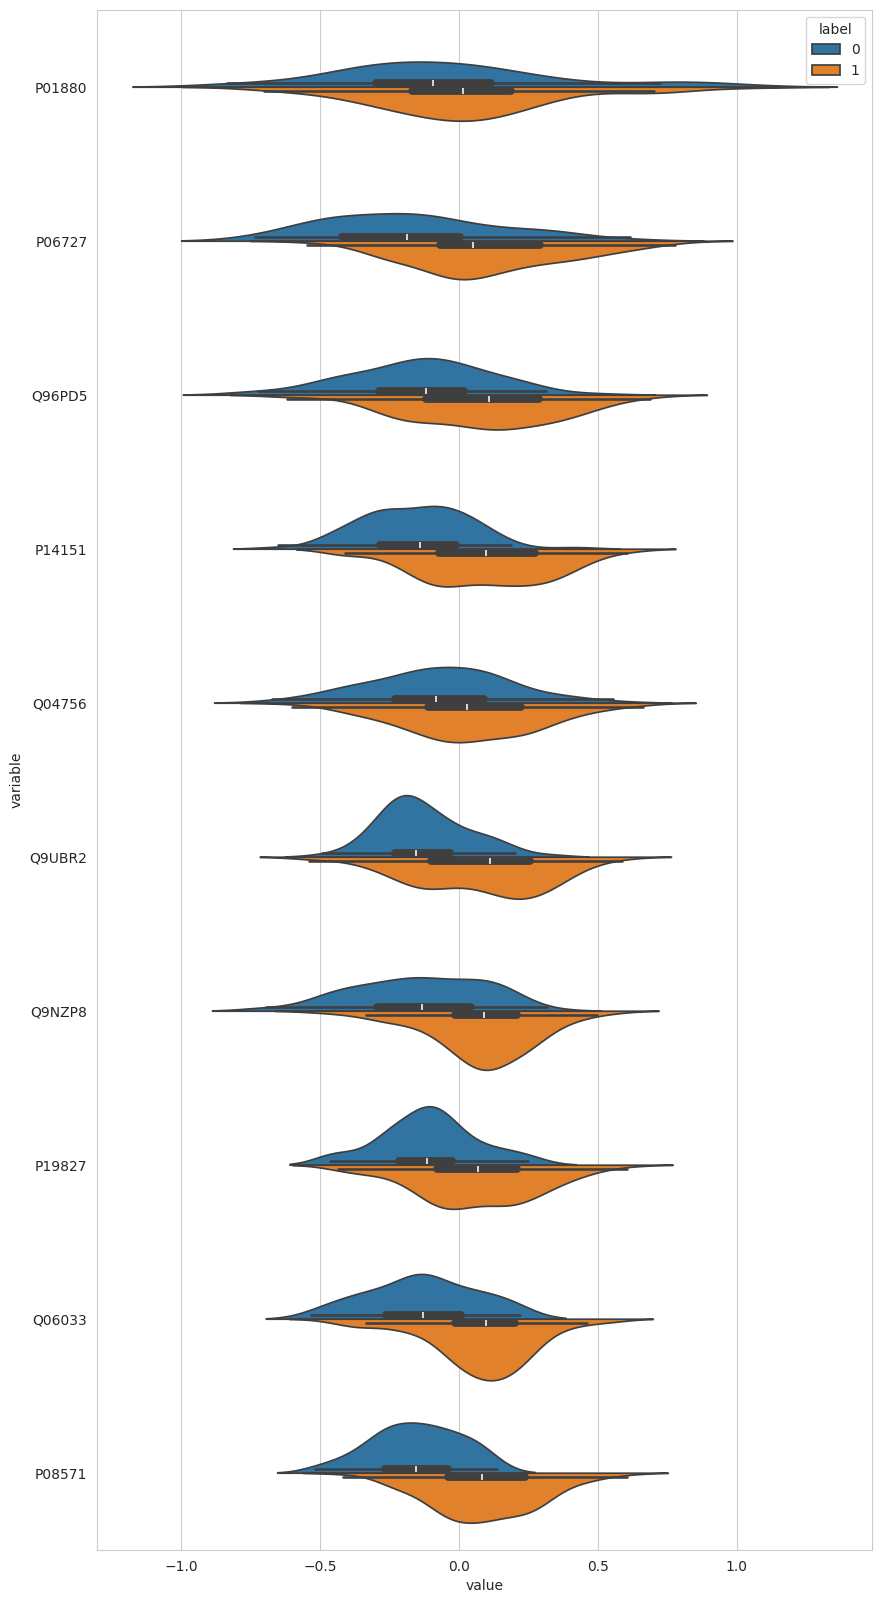

In [53]:
sns.set_style("whitegrid")

ax = sns.violinplot(
    data=explanations_melted,
    x="value",
    y="variable",
    hue="label",
    split=True
)

ax.figure.set_size_inches((10, 20))

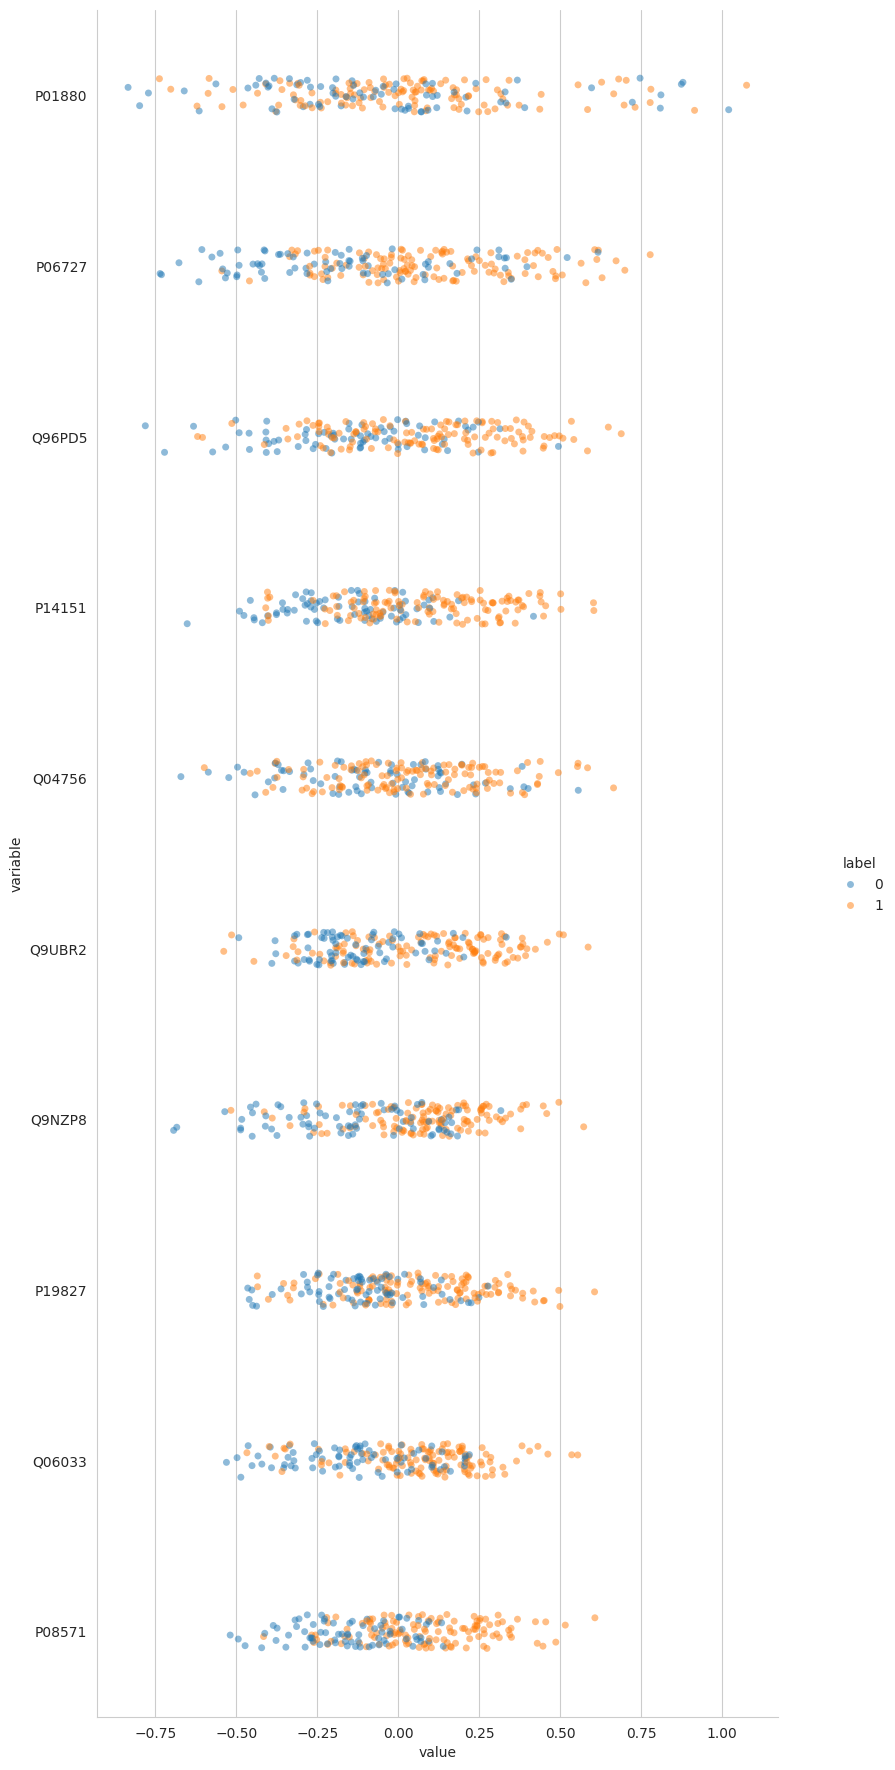

In [54]:
import matplotlib.pyplot as plt


# Show each observation with a scatterplot
ax = sns.catplot(data=explanations_melted, x="value", y="variable", hue="label", alpha=0.5)

ax.figure.set_size_inches((10, 20))
